# import & config

In [18]:
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
from scipy.stats import pearsonr
from skimage.metrics import structural_similarity as ssim

In [19]:
train_path = "./data/train"
test_path =  "./data/test"

# train 데이터 클래스 분포 확인

In [20]:
def analyze_class_distribution(train_dir: str, top_n: int = 10):
    """
    주어진 train 폴더 경로에서 클래스별 이미지 수를 세고,
    히스토그램을 그리고, 상위 N개 클래스명을 출력합니다.

    Args:
        train_dir (str): 'train' 폴더의 경로 (각 클래스 서브폴더 포함)
        top_n (int): 가장 많은 이미지를 가진 상위 클래스 개수
    """
    class_counts = {}

    # 클래스 폴더별 이미지 개수 계산
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        if os.path.isdir(class_path):
            image_files = [f for f in os.listdir(class_path) if f.lower().endswith('.jpg')]
            class_counts[class_name] = len(image_files)

    # 히스토그램 그리기
    sorted_classes = sorted(class_counts.items(), key=lambda x: x[0])  # 클래스명 기준 정렬
    labels, counts = zip(*sorted_classes)
    labels = [i for i in range(len(labels))]

    plt.figure(figsize=(18, 6))
    plt.bar(labels, counts)
    plt.xticks(rotation=90)
    plt.title("Class-wise Image Count")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()

    print(f"mean counts : {np.mean(counts)}")

    # 상위 N개 출력
    print(f"\nTop {top_n} classes with most images:")
    for cls, cnt in sorted(class_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]:
        print(f"{cls}: {cnt} images")
    

    # 하위 N개 출력
    print(f"\nUnder {top_n} classes with most images:")
    for cls, cnt in sorted(class_counts.items(), key=lambda x: x[1], reverse=False)[:top_n]:
        print(f"{cls}: {cnt} images")

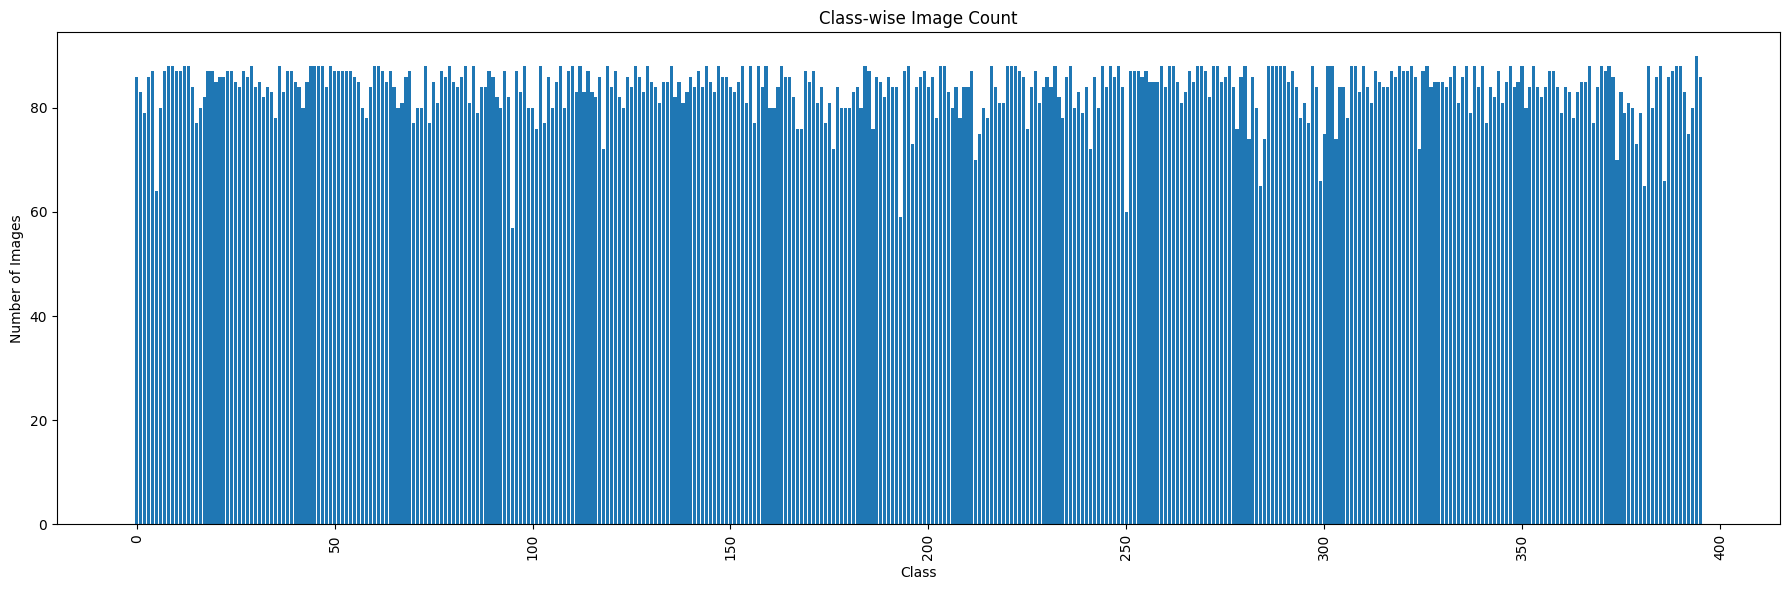

mean counts : 83.67929292929293

Top 20 classes with most images:
프리우스_4세대_2019_2022: 90 images
3시리즈_E90_2005_2012: 88 images
3시리즈_F30_2013_2018: 88 images
3시리즈_GT_F34_2014_2021: 88 images
4시리즈_F32_2014_2020: 88 images
7시리즈_G11_2019_2022: 88 images
A5_F5_2019_2024: 88 images
All_New_XJ_2016_2019: 88 images
B_클래스_W246_2013_2018: 88 images
CLA_클래스_C117_2014_2019: 88 images
CLA_클래스_C118_2020_2025: 88 images
CLS_클래스_C257_2019_2023: 88 images
EV6_2022_2024: 88 images
EV9_2024_2025: 88 images
G80_RG3_2025: 88 images
GLC_클래스_X253_2017_2019: 88 images
GLE_클래스_W166_2016_2018: 88 images
GLS_클래스_X166_2017_2019: 88 images
K7_프리미어_하이브리드_2020_2021: 88 images
M2_F87_2016_2021: 88 images

Under 20 classes with most images:
K5_3세대_하이브리드_2020_2022: 57 images
뉴_QM6_2021_2023: 59 images
디_올_뉴_스포티지_2022_2024: 60 images
2시리즈_액티브_투어러_F45_2019_2021: 64 images
마칸_2022_2024: 65 images
트레일블레이저_2023: 65 images
스타리아_2022_2025: 66 images
티볼리_에어_2021_2022: 66 images
더_뉴_K7_2013_2016: 70 images
토레스_2023_2025: 70 imag

In [21]:
analyze_class_distribution(train_path, 20)

# train/test 데이터 직접 확인해보기

In [5]:
def show_random_images_from_random_classes(train_dir: str, num_classes: int = 5):
    """
    주어진 train 디렉토리에서 무작위 클래스 N개를 선택하고, 각 클래스에서 랜덤 이미지를 하나씩 시각화합니다.

    Args:
        train_dir (str): 클래스 폴더들이 들어 있는 train 폴더 경로
        num_classes (int): 무작위로 선택할 클래스 수
    """
    all_classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
    selected_classes = random.sample(all_classes, min(num_classes, len(all_classes)))

    plt.figure(figsize=(4 * num_classes, 4))

    for idx, class_name in enumerate(selected_classes):
        class_dir = os.path.join(train_dir, class_name)
        image_files = [f for f in os.listdir(class_dir) if f.lower().endswith('.jpg')]
        if not image_files:
            continue
        img_path = os.path.join(class_dir, random.choice(image_files))
        img = Image.open(img_path)

        plt.subplot(1, num_classes, idx + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

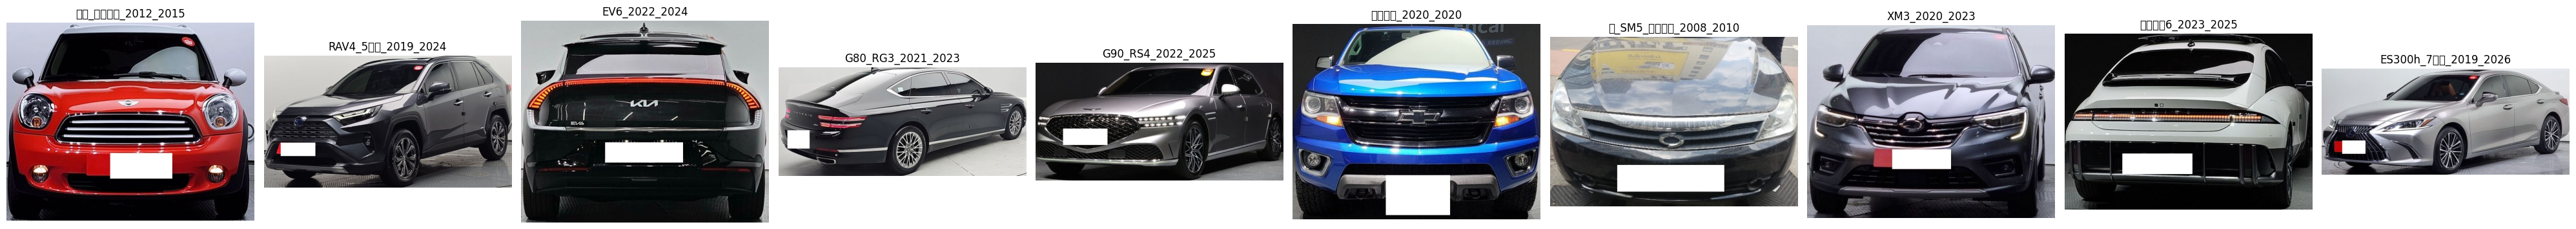

In [6]:
show_random_images_from_random_classes(train_path, 10)

# 평균 이미지 사이즈 확인

## train

In [7]:
def analyze_image_distribution_and_correlation(train_dir):
    widths, heights, sizes, ratios = [], [], [], []

    for root, _, files in os.walk(train_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, file)
                try:
                    with Image.open(img_path) as img:
                        w, h = img.size
                    size = os.path.getsize(img_path)

                    if h > 0:  # height가 0인 경우 방지
                        ratio = w / h
                        ratios.append(ratio)
                        widths.append(w)
                        heights.append(h)
                        sizes.append(size)
                except:
                    continue  # 깨진 파일 등 무시

    # 1. width, height, size 분포 시각화
    plt.figure(figsize=(30, 5))

    plt.subplot(1, 5, 1)
    plt.hist(widths, bins=50, color='skyblue')
    plt.title('Image Width Distribution')
    plt.xlabel('Width (px)')
    plt.ylabel('Count')

    plt.subplot(1, 5, 2)
    plt.hist(heights, bins=50, color='salmon')
    plt.title('Image Height Distribution')
    plt.xlabel('Height (px)')
    plt.ylabel('Count')

    plt.subplot(1, 5, 3)
    plt.hist(sizes, bins=50, color='lightgreen')
    plt.title('Image File Size Distribution')
    plt.xlabel('File Size (Bytes)')
    plt.ylabel('Count')

    # 2. width vs height 산점도
    plt.subplot(1, 5, 4)
    plt.scatter(widths, heights, alpha=0.3, s=5, color='purple')
    plt.title('Width vs Height Scatter Plot')
    plt.xlabel('Width (px)')
    plt.ylabel('Height (px)')
    plt.grid(True)

    # 3. aspect ratio 분포도 추가
    plt.subplot(1, 5, 5)
    plt.hist(ratios, bins=50, color='orange', edgecolor='black')
    plt.title('Aspect Ratio (Width / Height) Distribution')
    plt.xlabel('Aspect Ratio')
    plt.ylabel('Count')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 4. 상관계수
    if len(widths) > 1:
        corr_coef, p_value = pearsonr(widths, heights)
        print(f"📊 Pearson Correlation (Width vs Height): {corr_coef:.4f} (p = {p_value:.4e})")
    
    # 5. 평균 정보 출력
    if widths:
        print(f"\n📈 Total images       : {len(widths)}")
        print(f"Average Width         : {np.mean(widths):.2f} px")
        print(f"Average Height        : {np.mean(heights):.2f} px")
        print(f"Average File Size     : {np.mean(sizes):.2f} Bytes")
        print(f"Average Aspect Ratio  : {np.mean(ratios):.4f}")


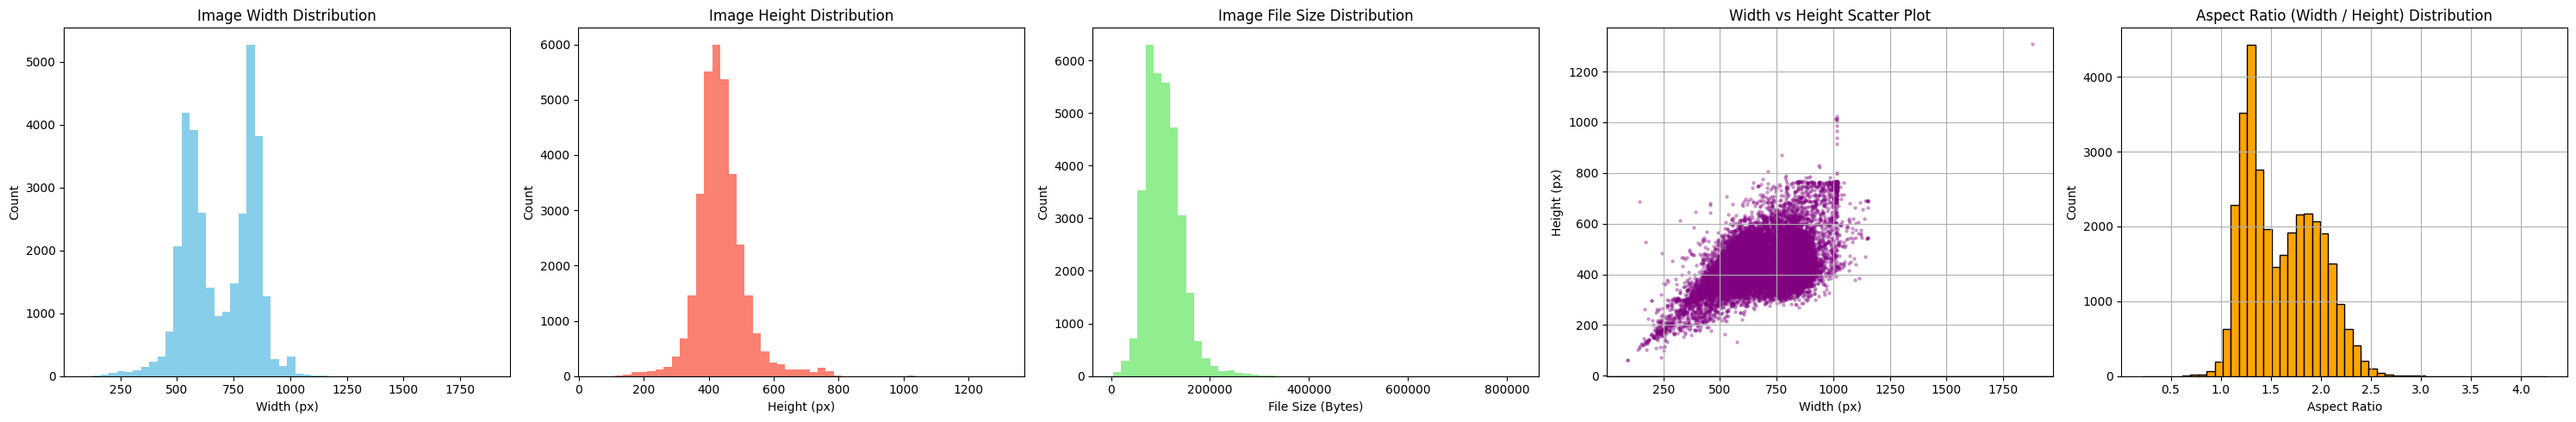

📊 Pearson Correlation (Width vs Height): 0.3607 (p = 0.0000e+00)

📈 Total images       : 33137
Average Width         : 690.29 px
Average Height        : 436.58 px
Average File Size     : 105906.62 Bytes
Average Aspect Ratio  : 1.6033


In [8]:
analyze_image_distribution_and_correlation(train_path)

## test

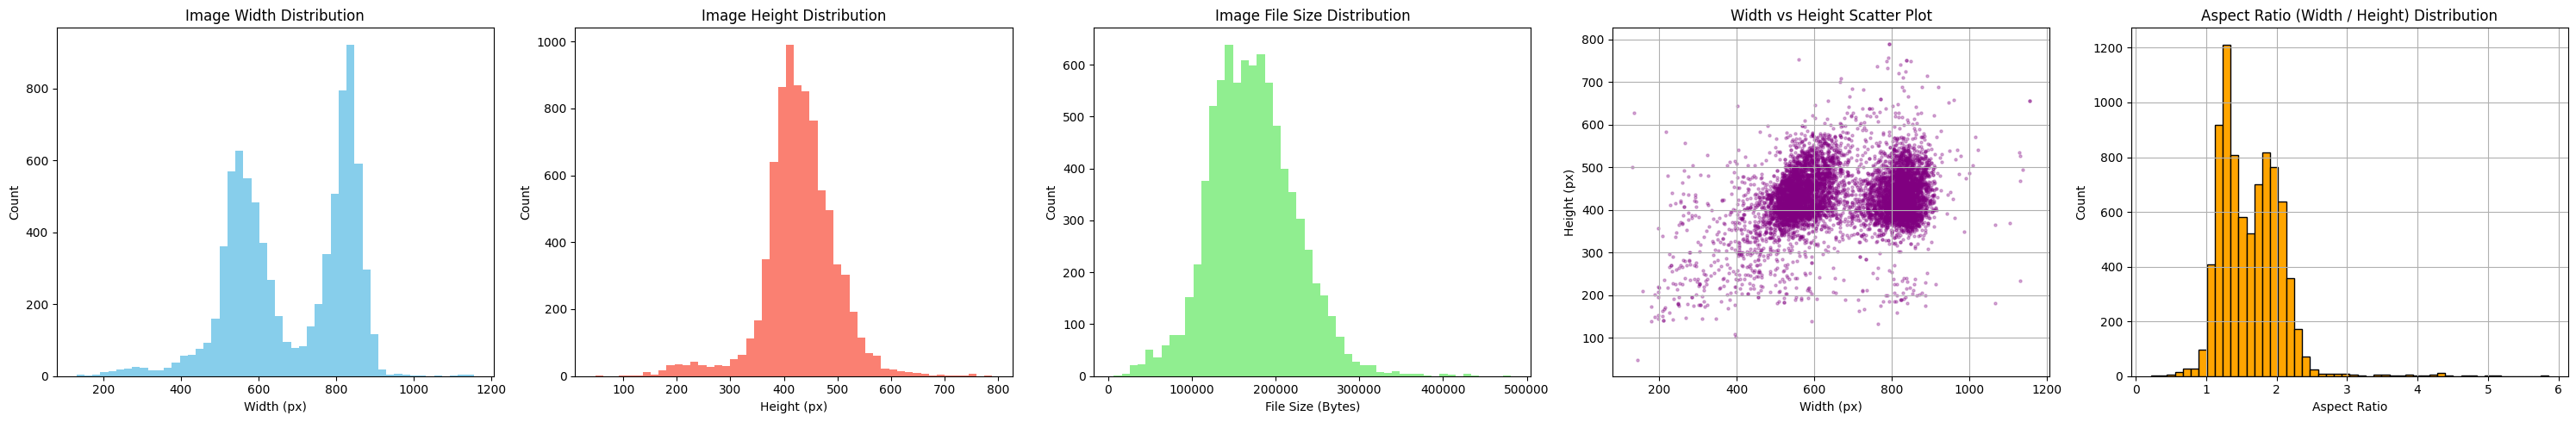

📊 Pearson Correlation (Width vs Height): 0.2359 (p = 8.3409e-105)

📈 Total images       : 8258
Average Width         : 682.87 px
Average Height        : 429.76 px
Average File Size     : 172921.53 Bytes
Average Aspect Ratio  : 1.6196


In [9]:
analyze_image_distribution_and_correlation(test_path)

# Brightness 분포

In [10]:
def analyze_brightness_and_features(root_folder):
    brightness_values = []
    saturation_values = []
    value_values = []

    for root, _, files in os.walk(root_folder):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, file)
                try:
                    with Image.open(img_path).convert('RGB') as img:
                        # Resize to speed up if needed
                        img = img.resize((256, 256))

                        # 1. Brightness: grayscale average
                        gray = img.convert('L')
                        brightness = np.array(gray).mean()
                        brightness_values.append(brightness)

                        # 2. Saturation & Value from HSV
                        hsv = img.convert('HSV')
                        hsv_np = np.array(hsv)
                        saturation = hsv_np[:, :, 1].mean()
                        value = hsv_np[:, :, 2].mean()

                        saturation_values.append(saturation)
                        value_values.append(value)
                except Exception as e:
                    continue  # 손상된 이미지 무시

    # 1. 시각화
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle("Image Brightness, Saturation, and Value Distributions", fontsize=15)

    axs[0].hist(brightness_values, bins=50, color='gray', edgecolor='black')
    axs[0].set_title("Brightness (Grayscale)")
    axs[0].set_xlabel("Brightness (0~255)")
    axs[0].set_ylabel("Count")

    axs[1].hist(saturation_values, bins=50, color='orange', edgecolor='black')
    axs[1].set_title("Saturation (HSV - S Channel)")
    axs[1].set_xlabel("Saturation (0~255)")
    axs[1].set_ylabel("Count")

    axs[2].hist(value_values, bins=50, color='blue', edgecolor='black')
    axs[2].set_title("Value (HSV - V Channel)")
    axs[2].set_xlabel("Value (0~255)")
    axs[2].set_ylabel("Count")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # 2. 통계 출력
    print(f"📊 Processed Images: {len(brightness_values)}")
    print(f"🟡 Brightness (Gray): Mean={np.mean(brightness_values):.2f}, Std={np.std(brightness_values):.2f}")
    print(f"🟠 Saturation (HSV S): Mean={np.mean(saturation_values):.2f}, Std={np.std(saturation_values):.2f}")
    print(f"🔵 Value (HSV V): Mean={np.mean(value_values):.2f}, Std={np.std(value_values):.2f}")


## train

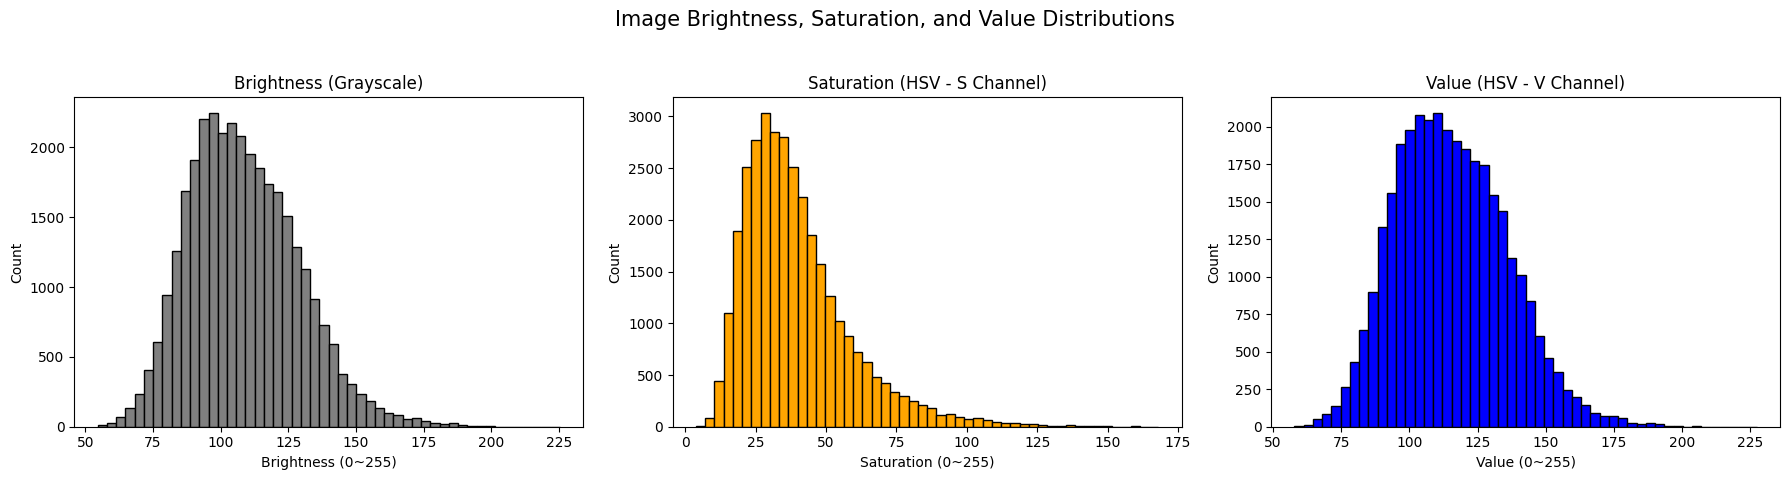

📊 Processed Images: 33137
🟡 Brightness (Gray): Mean=108.58, Std=20.27
🟠 Saturation (HSV S): Mean=39.53, Std=19.06
🔵 Value (HSV V): Mean=115.48, Std=20.43


In [11]:
analyze_brightness_and_features(train_path)

## test

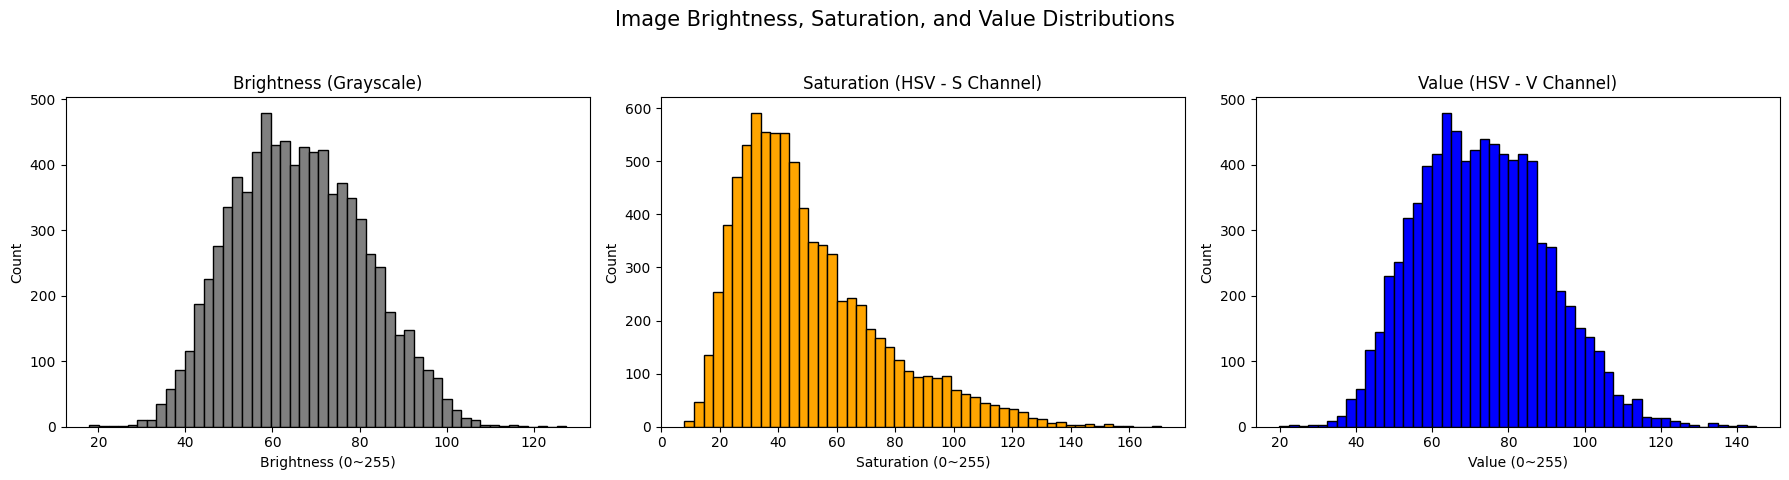

📊 Processed Images: 8258
🟡 Brightness (Gray): Mean=66.13, Std=14.88
🟠 Saturation (HSV S): Mean=50.12, Std=24.54
🔵 Value (HSV V): Mean=73.26, Std=16.84


In [12]:
analyze_brightness_and_features(test_path)

# 같은 클래스 내 유사도 검사?

In [15]:
import os
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim
from itertools import combinations
from tqdm import tqdm

def find_outlier_by_ssim(class_dir, resize_to=(512, 512)):
    """
    같은 클래스 디렉토리 안의 이미지들 간 SSIM 유사도를 계산해
    평균 SSIM이 가장 낮은 이미지를 아웃라이어로 판단합니다.

    Args:
        class_dir (str): 클래스 폴더 경로
        resize_to (tuple): 이미지 크기 표준화 (default: 256x256)
    """
    image_paths = [
        os.path.join(class_dir, f)
        for f in os.listdir(class_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    if len(image_paths) < 2:
        print("이미지가 2장 이상 있어야 SSIM 분석이 가능합니다.")
        return

    # 이미지 로딩 & 전처리 (grayscale, resize)
    images = []
    for path in image_paths:
        try:
            img = Image.open(path).convert("L").resize(resize_to)
            images.append((path, np.array(img)))
        except:
            print(f"불러오기 실패: {path}")

    N = len(images)
    ssim_matrix = np.zeros((N, N))

    # SSIM 계산 (하나의 삼각 행렬만 계산해도 충분)
    for (i, (p1, im1)), (j, (p2, im2)) in tqdm(combinations(enumerate(images), 2), total=N*(N-1)//2, desc="Calculating SSIM"):
        score = ssim(im1, im2)
        ssim_matrix[i, j] = score
        ssim_matrix[j, i] = score

    # 평균 SSIM 계산 (자기 자신 제외)
    avg_ssim_per_image = (np.sum(ssim_matrix, axis=1) - 1) / (N - 1)

    # 가장 평균 SSIM이 낮은 이미지 찾기
    outlier_index = np.argmin(avg_ssim_per_image)
    outlier_path = images[outlier_index][0]

    # 결과 출력
    print(f"\n🚨 Outlier (가장 유사도가 낮은 이미지): {os.path.basename(outlier_path)}")
